In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

import pylops
from pylops.basicoperators import *
from pylops.utils.wavelets import ricker
from pylops.utils import wavelets
from pylops.utils.backend import get_array_module
from pylops.avo.avo import *
from pylops.avo.prestack import *

plt.close('all')
np.random.seed(0)

In [2]:
# model
nt0 = 301
dt0 = 0.004

t0 = np.arange(nt0)*dt0
vp = 1200 + np.arange(nt0) + \
     filtfilt(np.ones(5)/5., 1, np.random.normal(0, 80, nt0))
vs = 600  + vp/2 + \
     filtfilt(np.ones(5)/5., 1, np.random.normal(0, 20, nt0))
rho = 1000 + vp + \
      filtfilt(np.ones(5)/5., 1, np.random.normal(0, 30, nt0))
vp[131:] += 500
vs[131:] += 200
rho[131:] += 100
vsvp = 0.5
m = np.stack((np.log(vp*rho), np.log(vs*rho), np.log(rho)), axis=1)

# background model
nsmooth = 50
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m, axis=0)

# angles
ntheta = 21
thetamin, thetamax = 0, 40
theta = np.linspace(thetamin, thetamax, ntheta)

# wavelet
ntwav = 41
wav = ricker(t0[:ntwav//2+1], 15)[0]

# lop
PPop = \
    PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization='fatti')
PSop = \
    PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization='ps')
PPPSop = VStack((PPop, PSop))


# dense
PPop_dense = \
    PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization='fatti', explicit=True)
PSop_dense = \
    PrestackLinearModelling(wav, theta, vsvp=vsvp, nt0=nt0, linearization='ps', explicit=True)
PPPSop_dense = VStack((PPop_dense, PSop_dense))

# data lop
dPPPS = PPPSop*m.flatten()
dPPPS = dPPPS.reshape(2, nt0, ntheta)

# data dense
dPPPS_dense = PPPSop_dense*m.T.flatten()
dPPPS_dense = dPPPS_dense.reshape(2, ntheta, nt0).transpose(0, 2, 1)

# noisy data
dPPPSn_dense = dPPPS_dense + np.random.normal(0, 1e-2, dPPPS_dense.shape)

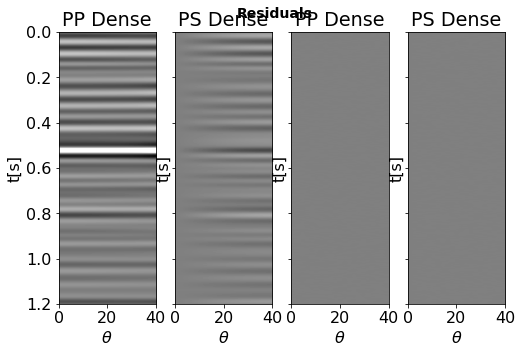

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
fig.suptitle('Residuals', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(dPPPS[0], cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[0].set_title('PP Dense')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('t[s]')
axs[0].axis('tight')
im = axs[1].imshow(dPPPS[1], cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[1].set_title('PS Dense')
axs[1].set_xlabel(r'$\theta$')
axs[1].set_ylabel('t[s]')
axs[1].axis('tight')
im = axs[2].imshow(dPPPS[0]-dPPPS_dense[0], cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[2].set_title('PP Dense')
axs[2].set_xlabel(r'$\theta$')
axs[2].set_ylabel('t[s]')
axs[2].axis('tight')
im = axs[3].imshow(dPPPS[1]-dPPPS_dense[1], cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[3].set_title('PS Dense')
axs[3].set_xlabel(r'$\theta$')
axs[3].set_ylabel('t[s]')
axs[3].axis('tight');

## PP inversion

In [4]:
# dense
minv_dense, dPP_dense_res = \
    PrestackInversion(dPPPS_dense[0], theta, wav, m0=mback,
                      linearization='fatti',
                      explicit=True, returnres=True,
                      **dict(cond=1e-10))

# lop
minv, dPP_res = \
    PrestackInversion(dPPPS[0], theta, wav, m0=mback,
                      linearization='fatti',
                      explicit=False, returnres=True,
                      **dict(damp=1e-10, iter_lim=2000))

# dense noisy
minv_dense_noise, dPPn_dense_res = \
    PrestackInversion(dPPPSn_dense[0], theta, wav, m0=mback,
                      linearization='fatti',
                      explicit=True,
                      returnres=True, **dict(cond=1e-1))

# lop noisy (with vertical smoothing)
minv_noise, dPPn_res = \
    PrestackInversion(dPPPSn_dense[0], theta, wav, m0=mback,
                      linearization='fatti',
                      explicit=False,
                      epsR=5e-1, returnres=True,
                      **dict(damp=1e-1, iter_lim=100))

MSE IP 2142064.93823337
MSE IS 1654457.0882047135
MSE RHO 735.6939092228363


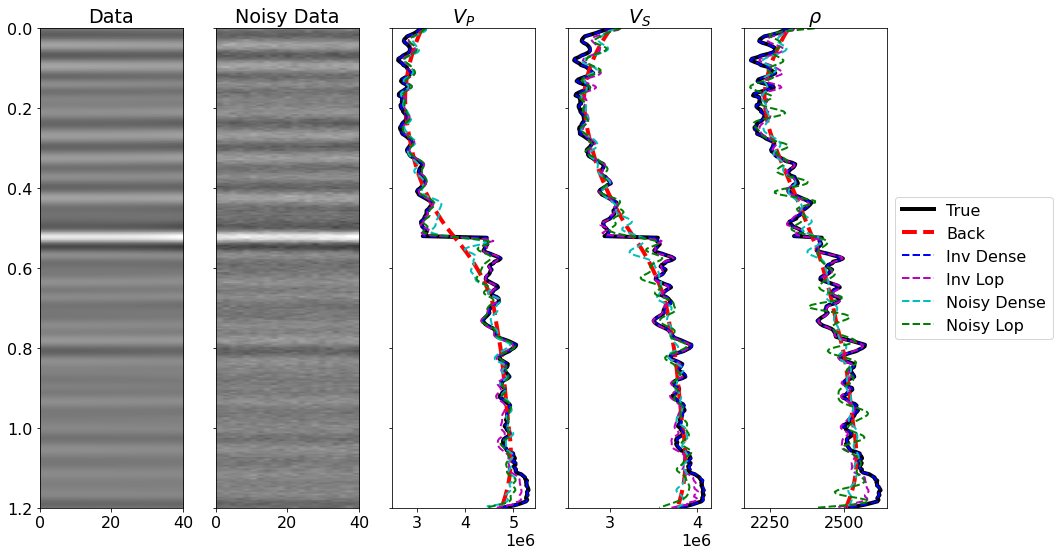

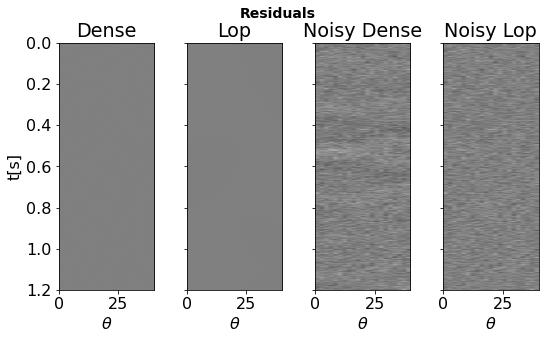

In [5]:
# Error norms
print('MSE IP', np.linalg.norm(vp*rho-np.exp(minv_noise[:, 0])))
print('MSE IS', np.linalg.norm(vs*rho-np.exp(minv_noise[:, 1])))
print('MSE RHO', np.linalg.norm(rho-np.exp(minv_noise[:, 2])))

# Data and model
fig, (axd, axdn, axvp, axvs, axrho) = \
    plt.subplots(1, 5, figsize=(15, 8), sharey=True)
axd.imshow(dPPPS_dense[0], cmap='gray',
           extent=(theta[0], theta[-1], t0[-1], t0[0]),
           vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axd.set_title('Data')
axd.axis('tight')
axdn.imshow(dPPPSn_dense[0], cmap='gray',
            extent=(theta[0], theta[-1], t0[-1], t0[0]),
            vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axdn.set_title('Noisy Data')
axdn.axis('tight')
axvp.plot(vp*rho, t0, 'k', lw=4, label='True')
axvp.plot(np.exp(mback[:, 0]), t0, '--r', lw=4, label='Back')
axvp.plot(np.exp(minv_dense[:, 0]), t0, '--b', lw=2, label='Inv Dense')
axvp.plot(np.exp(minv[:, 0]), t0, '--m', lw=2, label='Inv Lop')
axvp.plot(np.exp(minv_dense_noise[:, 0]), t0, '--c', lw=2, label='Noisy Dense')
axvp.plot(np.exp(minv_noise[:, 0]), t0, '--g', lw=2, label='Noisy Lop')
axvp.set_title(r'$V_P$')
axvs.plot(vs*rho, t0, 'k', lw=4, label='True')
axvs.plot(np.exp(mback[:, 1]), t0, '--r', lw=4, label='Back')
axvs.plot(np.exp(minv_dense[:, 1]), t0, '--b', lw=2, label='Inv Dense')
axvs.plot(np.exp(minv[:, 1]), t0, '--m', lw=2, label='Inv Lop')
axvs.plot(np.exp(minv_dense_noise[:, 1]), t0, '--c', lw=2, label='Noisy Dense')
axvs.plot(np.exp(minv_noise[:, 1]), t0, '--g', lw=2, label='Noisy Lop')
axvs.set_title(r'$V_S$')
axrho.plot(rho, t0, 'k', lw=4, label='True')
axrho.plot(np.exp(mback[:, 2]), t0, '--r', lw=4, label='Back')
axrho.plot(np.exp(minv_dense[:, 2]), t0, '--b', lw=2, label='Inv Dense')
axrho.plot(np.exp(minv[:, 2]), t0, '--m', lw=2, label='Inv Lop')
axrho.plot(np.exp(minv_dense_noise[:, 2]),
           t0, '--c', lw=2, label='Noisy Dense')
axrho.plot(np.exp(minv_noise[:, 2]), t0, '--g', lw=2, label='Noisy Lop')
axrho.set_title(r'$\rho$')
axrho.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axd.axis('tight')
plt.tight_layout()

# Residuals
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
fig.suptitle('Residuals', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(dPP_dense_res, cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[0].set_title('Dense')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('t[s]')
axs[0].axis('tight')
axs[1].imshow(dPP_res, cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[1].set_title('Lop')
axs[1].set_xlabel(r'$\theta$')
axs[1].axis('tight')
axs[2].imshow(dPPn_dense_res, cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[2].set_title('Noisy Dense')
axs[2].set_xlabel(r'$\theta$')
axs[2].axis('tight')
axs[3].imshow(dPPn_res, cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[3].set_title('Noisy Lop')
axs[3].set_xlabel(r'$\theta$')
axs[3].axis('tight')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

## PS Inversion

In [6]:
# dense
minv_dense, dPP_dense_res = \
    PrestackInversion(dPPPS_dense[1], theta, wav, m0=mback,
                      linearization='ps',
                      explicit=True, returnres=True,
                      **dict(cond=1e-10))

# lop
minv, dPP_res = \
    PrestackInversion(dPPPS[1], theta, wav, m0=mback,
                      linearization='ps',
                      explicit=False, returnres=True,
                      **dict(damp=1e-10, iter_lim=2000))

# dense noisy
minv_dense_noise, dPPn_dense_res = \
    PrestackInversion(dPPPSn_dense[1], theta, wav, m0=mback,
                      linearization='ps',
                      explicit=True,
                      returnres=True, **dict(cond=1e-1))

# lop noisy (with vertical smoothing)
minv_noise, dPPn_res = \
    PrestackInversion(dPPPSn_dense[1], theta, wav, m0=mback,
                      linearization='ps',
                      explicit=False,
                      epsR=5e-1, returnres=True,
                      **dict(damp=1e-1, iter_lim=100))

MSE IP 3802117.7210865146
MSE IS 1630201.259326063
MSE RHO 666.8571600075342


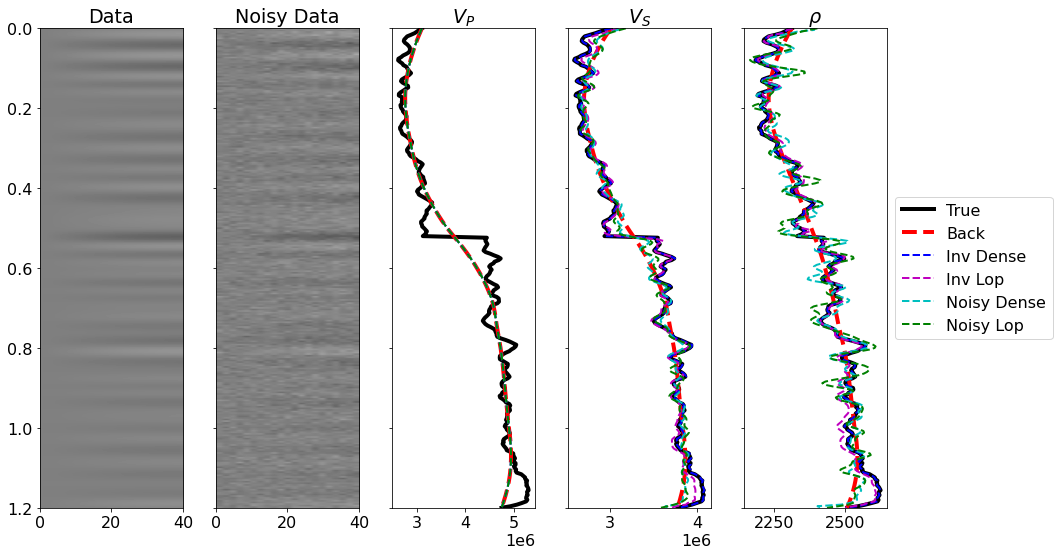

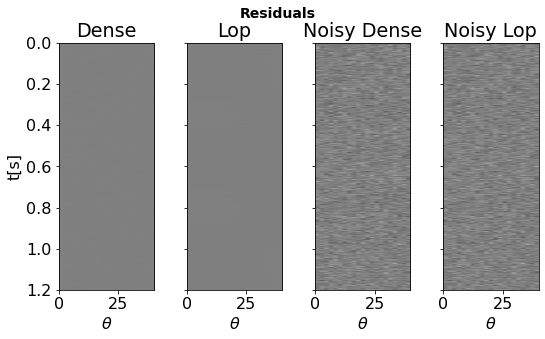

In [7]:
# Error norms
print('MSE IP', np.linalg.norm(vp*rho-np.exp(minv_noise[:, 0])))
print('MSE IS', np.linalg.norm(vs*rho-np.exp(minv_noise[:, 1])))
print('MSE RHO', np.linalg.norm(rho-np.exp(minv_noise[:, 2])))

# Data and model
fig, (axd, axdn, axvp, axvs, axrho) = \
    plt.subplots(1, 5, figsize=(15, 8), sharey=True)
axd.imshow(dPPPS_dense[1], cmap='gray',
           extent=(theta[0], theta[-1], t0[-1], t0[0]),
           vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axd.set_title('Data')
axd.axis('tight')
axdn.imshow(dPPPSn_dense[1], cmap='gray',
            extent=(theta[0], theta[-1], t0[-1], t0[0]),
            vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axdn.set_title('Noisy Data')
axdn.axis('tight')
axvp.plot(vp*rho, t0, 'k', lw=4, label='True')
axvp.plot(np.exp(mback[:, 0]), t0, '--r', lw=4, label='Back')
axvp.plot(np.exp(minv_dense[:, 0]), t0, '--b', lw=2, label='Inv Dense')
axvp.plot(np.exp(minv[:, 0]), t0, '--m', lw=2, label='Inv Lop')
axvp.plot(np.exp(minv_dense_noise[:, 0]), t0, '--c', lw=2, label='Noisy Dense')
axvp.plot(np.exp(minv_noise[:, 0]), t0, '--g', lw=2, label='Noisy Lop')
axvp.set_title(r'$V_P$')
axvs.plot(vs*rho, t0, 'k', lw=4, label='True')
axvs.plot(np.exp(mback[:, 1]), t0, '--r', lw=4, label='Back')
axvs.plot(np.exp(minv_dense[:, 1]), t0, '--b', lw=2, label='Inv Dense')
axvs.plot(np.exp(minv[:, 1]), t0, '--m', lw=2, label='Inv Lop')
axvs.plot(np.exp(minv_dense_noise[:, 1]), t0, '--c', lw=2, label='Noisy Dense')
axvs.plot(np.exp(minv_noise[:, 1]), t0, '--g', lw=2, label='Noisy Lop')
axvs.set_title(r'$V_S$')
axrho.plot(rho, t0, 'k', lw=4, label='True')
axrho.plot(np.exp(mback[:, 2]), t0, '--r', lw=4, label='Back')
axrho.plot(np.exp(minv_dense[:, 2]), t0, '--b', lw=2, label='Inv Dense')
axrho.plot(np.exp(minv[:, 2]), t0, '--m', lw=2, label='Inv Lop')
axrho.plot(np.exp(minv_dense_noise[:, 2]),
           t0, '--c', lw=2, label='Noisy Dense')
axrho.plot(np.exp(minv_noise[:, 2]), t0, '--g', lw=2, label='Noisy Lop')
axrho.set_title(r'$\rho$')
axrho.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axd.axis('tight')
plt.tight_layout()

# Residuals
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
fig.suptitle('Residuals', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(dPP_dense_res, cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[0].set_title('Dense')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('t[s]')
axs[0].axis('tight')
axs[1].imshow(dPP_res, cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[1].set_title('Lop')
axs[1].set_xlabel(r'$\theta$')
axs[1].axis('tight')
axs[2].imshow(dPPn_dense_res, cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[2].set_title('Noisy Dense')
axs[2].set_xlabel(r'$\theta$')
axs[2].axis('tight')
axs[3].imshow(dPPn_res, cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[3].set_title('Noisy Lop')
axs[3].set_xlabel(r'$\theta$')
axs[3].axis('tight')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

## PP+PS inversion

In [8]:
# dense
minv_dense, dPP_dense_res = \
    PrestackInversion(dPPPS_dense, theta, [wav, wav], m0=mback,
                      linearization=['fatti', 'ps'],
                      explicit=True, returnres=True,
                      **dict(cond=1e-10))

# lop
minv, dPP_res = \
    PrestackInversion(dPPPS, theta, [wav, wav], m0=mback,
                      linearization=['fatti', 'ps'],
                      explicit=False, returnres=True,
                      **dict(damp=1e-10, iter_lim=2000))

# dense noisy
minv_dense_noise, dPPn_dense_res = \
    PrestackInversion(dPPPSn_dense, theta, [wav, wav], m0=mback,
                      linearization=['fatti', 'ps'],
                      explicit=True,
                      returnres=True, **dict(cond=1e-1))

# lop noisy (with vertical smoothing)
minv_noise, dPPn_res = \
    PrestackInversion(dPPPSn_dense, theta, [wav, wav], m0=mback,
                      linearization=['fatti', 'ps'],
                      explicit=False,
                      epsR=5e-1, returnres=True,
                      **dict(damp=1e-1, iter_lim=100))

MSE IP 2131596.879756578
MSE IS 1574954.3366329372
MSE RHO 630.525679356292


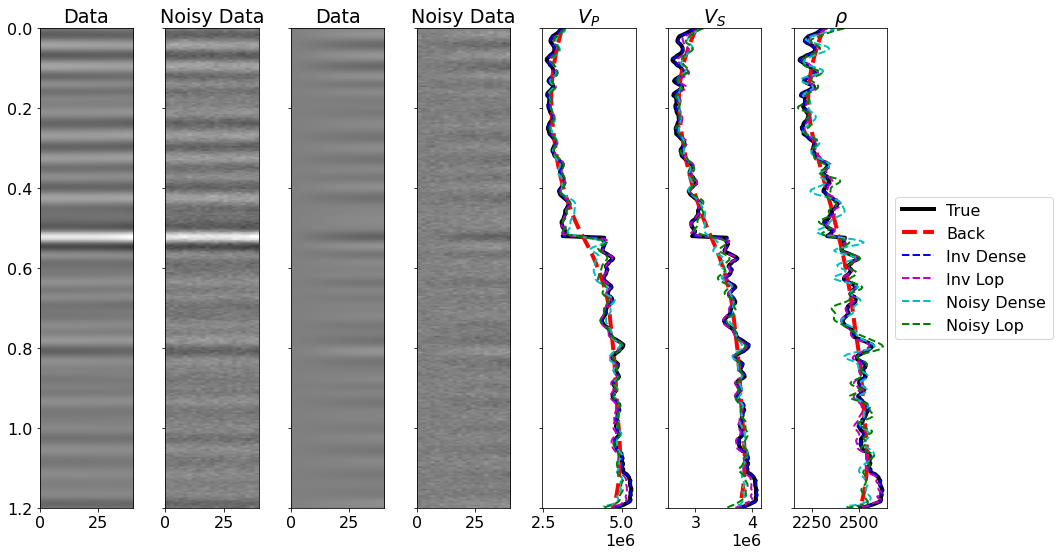

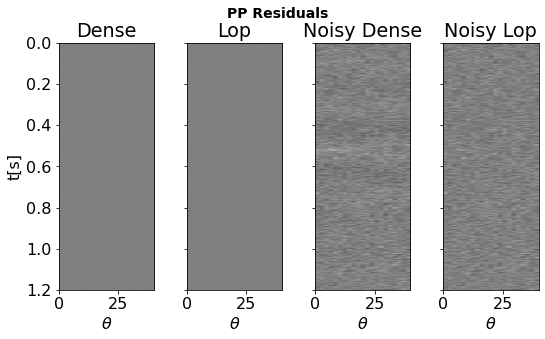

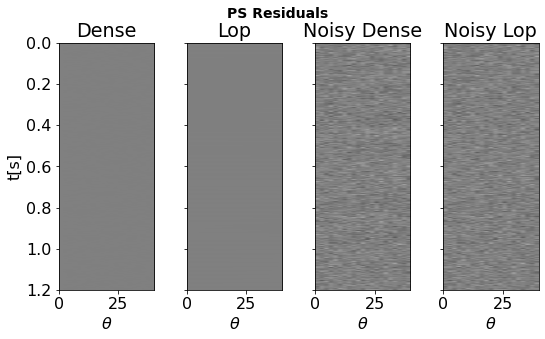

In [9]:
# Error norms
print('MSE IP', np.linalg.norm(vp*rho-np.exp(minv_noise[:, 0])))
print('MSE IS', np.linalg.norm(vs*rho-np.exp(minv_noise[:, 1])))
print('MSE RHO', np.linalg.norm(rho-np.exp(minv_noise[:, 2])))

# Data and model
fig, (axpp, axppn, axps, axpsn, axvp, axvs, axrho) = \
    plt.subplots(1, 7, figsize=(15, 8), sharey=True)
axpp.imshow(dPPPS_dense[0], cmap='gray',
           extent=(theta[0], theta[-1], t0[-1], t0[0]),
           vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axpp.set_title('Data')
axpp.axis('tight')
axppn.imshow(dPPPSn_dense[0], cmap='gray',
            extent=(theta[0], theta[-1], t0[-1], t0[0]),
            vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axppn.set_title('Noisy Data')
axppn.axis('tight')
axps.imshow(dPPPS_dense[1], cmap='gray',
           extent=(theta[0], theta[-1], t0[-1], t0[0]),
           vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axps.set_title('Data')
axps.axis('tight')
axpsn.imshow(dPPPSn_dense[1], cmap='gray',
            extent=(theta[0], theta[-1], t0[-1], t0[0]),
            vmin=-np.abs(dPPPS_dense).max(), vmax=np.abs(dPPPS_dense).max())
axpsn.set_title('Noisy Data')
axpsn.axis('tight')
axvp.plot(vp*rho, t0, 'k', lw=4, label='True')
axvp.plot(np.exp(mback[:, 0]), t0, '--r', lw=4, label='Back')
axvp.plot(np.exp(minv_dense[:, 0]), t0, '--b', lw=2, label='Inv Dense')
axvp.plot(np.exp(minv[:, 0]), t0, '--m', lw=2, label='Inv Lop')
axvp.plot(np.exp(minv_dense_noise[:, 0]), t0, '--c', lw=2, label='Noisy Dense')
axvp.plot(np.exp(minv_noise[:, 0]), t0, '--g', lw=2, label='Noisy Lop')
axvp.set_title(r'$V_P$')
axvs.plot(vs*rho, t0, 'k', lw=4, label='True')
axvs.plot(np.exp(mback[:, 1]), t0, '--r', lw=4, label='Back')
axvs.plot(np.exp(minv_dense[:, 1]), t0, '--b', lw=2, label='Inv Dense')
axvs.plot(np.exp(minv[:, 1]), t0, '--m', lw=2, label='Inv Lop')
axvs.plot(np.exp(minv_dense_noise[:, 1]), t0, '--c', lw=2, label='Noisy Dense')
axvs.plot(np.exp(minv_noise[:, 1]), t0, '--g', lw=2, label='Noisy Lop')
axvs.set_title(r'$V_S$')
axrho.plot(rho, t0, 'k', lw=4, label='True')
axrho.plot(np.exp(mback[:, 2]), t0, '--r', lw=4, label='Back')
axrho.plot(np.exp(minv_dense[:, 2]), t0, '--b', lw=2, label='Inv Dense')
axrho.plot(np.exp(minv[:, 2]), t0, '--m', lw=2, label='Inv Lop')
axrho.plot(np.exp(minv_dense_noise[:, 2]),
           t0, '--c', lw=2, label='Noisy Dense')
axrho.plot(np.exp(minv_noise[:, 2]), t0, '--g', lw=2, label='Noisy Lop')
axrho.set_title(r'$\rho$')
axrho.legend(loc='center left', bbox_to_anchor=(1, 0.5))
axd.axis('tight')
plt.tight_layout()

# Residuals
fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
fig.suptitle('PP Residuals', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(dPP_dense_res[0], cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[0].set_title('Dense')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('t[s]')
axs[0].axis('tight')
axs[1].imshow(dPP_res[0], cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[1].set_title('Lop')
axs[1].set_xlabel(r'$\theta$')
axs[1].axis('tight')
axs[2].imshow(dPPn_dense_res[0], cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[2].set_title('Noisy Dense')
axs[2].set_xlabel(r'$\theta$')
axs[2].axis('tight')
axs[3].imshow(dPPn_res[0], cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[3].set_title('Noisy Lop')
axs[3].set_xlabel(r'$\theta$')
axs[3].axis('tight')
plt.tight_layout()
plt.subplots_adjust(top=0.85)

fig, axs = plt.subplots(1, 4, figsize=(8, 5), sharey=True)
fig.suptitle('PS Residuals', fontsize=14,
             fontweight='bold', y=0.95)
im = axs[0].imshow(dPP_dense_res[1], cmap='gray',
                   extent=(theta[0], theta[-1], t0[-1], t0[0]),
                   vmin=-0.1, vmax=0.1)
axs[0].set_title('Dense')
axs[0].set_xlabel(r'$\theta$')
axs[0].set_ylabel('t[s]')
axs[0].axis('tight')
axs[1].imshow(dPP_res[1], cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[1].set_title('Lop')
axs[1].set_xlabel(r'$\theta$')
axs[1].axis('tight')
axs[2].imshow(dPPn_dense_res[1], cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[2].set_title('Noisy Dense')
axs[2].set_xlabel(r'$\theta$')
axs[2].axis('tight')
axs[3].imshow(dPPn_res[1], cmap='gray',
              extent=(theta[0], theta[-1], t0[-1], t0[0]),
              vmin=-0.1, vmax=0.1)
axs[3].set_title('Noisy Lop')
axs[3].set_xlabel(r'$\theta$')
axs[3].axis('tight')
plt.tight_layout()
plt.subplots_adjust(top=0.85)